# 粒子滤波器Particle-Filters

    本节介绍例子滤波器，这个滤波器的想法类似于UKF方法，只是取消了UKF方法中sigma点的获取，改而采用Monte-Carlo随机种子方法。这种情况下描述同一状态的描述点相比于UKF更多，能有更大可能对状态估计更加准确。粒子群是建立在Monte-Carlo随机数的方法上的，通常在使用过程分为：已知初始状态而采用高斯分布处理；未知初始状态而采用均匀分布处理。

## 算法

接下来先给出整个算法过程，并分别叙述。

**初始化：**

1. 确定NL个标定点的位置：landmarkd = [ [ ], [ ],……]
2. 生成有N个随机点构成的粒子群：

    是否存在初始状态变量initial_x：
    - 存在：采用高斯分布方法：create_gaussian_particles(mean, P_std, N)
    - 不存在： 采用均匀分布方法：create_uniform_particles(x_range, y_range, …, N)
3. 初始化权系数：weights = np.zeros(N)

**循环部：**

4. 粒子群状态先验预估计：predict(particles, u, Q_std)
5. 生成状态测量值：zs
6. 粒子群状态后验估计： update(particles, weights, z, R_std, landmarks)
7. Resample判断：
    
    若系数 neff(weights) < N/2,  
    则：获取重抽样索引：indexes,
      重抽样：resample_from_indexes(particles, weights, indexes)
8. 状态变量估计：$\mu, \sigma^2$ = estimate(particles,weights)

接下来，我们给一个例题，并在例题前，逐步讲解每一个步骤的内容：

# 生成粒子群

前面已经知道了，通常粒子群生成有两种方案。  
在我们未知初值情况下，我们采用均匀分布设置N个随机点，这样有利于等可能的考虑到全域内任何一个可能出现新状态的位置。但是这样显然会相比于已知初始点，而在初始点处采用高斯分布来设置随机点的方法更加粗糙，更加不精确。因此，通常情况下，我们更愿意采用高斯分布的方法，而未知的初值，我们可以假设为接近初始测量值的值。

In [17]:
from numpy.random import uniform
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, P_std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * P_std[0])
    particles[:, 1] = mean[1] + (randn(N) * P_std[1])
    particles[:, 2] = mean[2] + (randn(N) * P_std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

## 状态先验假设预估计

预估计阶段，事实上就是对这些粒子点在dt时间后的位置先验假设估计，从而使粒子群从前一状态推移到新状态附近。

In [18]:
def predict(particles, u, Q_std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * Q_std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * Q_std[1])                #u[1]是速度控制标量，randn(N)是N维随机矢量
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

## 状态后验假设估计

后验假设估计过程，事实上就是将标定点测量到每个粒子的测量值融合以它的预估计值，按照高斯分布特性赋予它准确性，也即是更新每个粒子所能够拥有的权值weight。

In [19]:
def update(particles, weights, z, R_std, landmarks):
    weights.fill(1.)
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1) # axis=1: 横向求两点间距离（方和根）），纵向维数一致； axis=0: 纵向求方和根
        weights *= scipy.stats.norm(distance, R_std).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

## Resample判断系数neff(weights)

这一步是在求解的值是有效N，当有效N值小于N/2时（有时候也用N），则我们认为，这个时候有很多的点已经贡献值很小了，我们可以将它忽略掉。

In [20]:
def neff(weights):
    return 1. / np.sum(np.square(weights))   # 这里的square函数是标量运算，是对数组中每个元素进行运算操作

## Resample

进而，我们就将那些权值较大的点，也就是距离目标较近的粒子点保留下来。  
在这时，在获取这些粒子点的索引时候，通常有四种方法：
```python
import filterpy.monte-carlo as mc
mc.multinomial_resample
mc.residual_resample
mc.stratified_resample
mc.systematic_resample
```
这四种方法中，推荐使用后两种，其效率较高，具体对比可以参看书中最后部分。

In [21]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill (1.0 / len(weights))

## estimate

最后的估计部分，实际上就是对每个粒子作用于他自己的权值，从而获得这一状态的估计值，粒子分布的方差也就是这一状态的不确定性。

In [22]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)  #此时保持横向维度不变，纵向求均值，即对各粒子点加权求均值
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

final position error, variance:
	 [-0.10621456  0.1061402 ] [ 0.00859646  0.00757081]


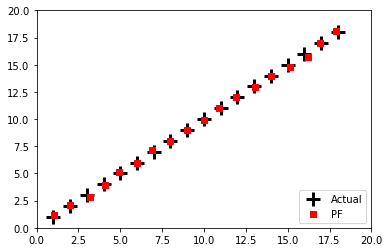

In [23]:
from filterpy.monte_carlo import systematic_resample
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
import matplotlib.pyplot as plt
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, P_std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.zeros(N)

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + 
              (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), Q_std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R_std=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)          # 采用systematic_resample方法获取重抽样索引
            resample_from_index(particles, weights, indexes)

        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=False)


最后我们看一下这样过程的一个动图来深入了解！！！


<img src='particle_filter_anim.gif'>